In [25]:
with open("/Users/paigegiese/Downloads/html_file_1_r-new-2025-0432.html", "r", encoding="utf-8") as f:
    raw = f.read()  

with open("/Users/paigegiese/Downloads/html_file_1_r-new-2025-0446.html", "r", encoding="utf-8") as f:
    raw2 = f.read()  

with open("/Users/paigegiese/Downloads/html_file_1_r-new-2025-0454.html", "r", encoding="utf-8") as f:
    raw3 = f.read()  



<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Transitional//EN" "http://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd"><html ng-app="appAca" xmlns="http://www.w3.org/1999/xhtml" lang="en-US" xml:lang="en-US" xmlns:og="http://ogp.me/ns#" xmlns:fb="http://www.facebook.com/2008/fbml" dir=""><head id="ctl00_Head1"><link href="../App_Themes/Default/form.css" type="text/css" rel="stylesheet"><link href="../App_Themes/Default/style.css" type="text/css" rel="stylesheet"><title>
	
        Accela Citizen Access
    
</title><meta http-equiv="Content-Type" content="text/html; charset=utf-8"><meta name="viewport" content="width=device-width, initial-scale=1.0">
    <style type="text/css">
        body, html {
        overflow-y: visible!important;
        }
        .page-overlay-blocker {
          position: fixed;
          z-index: 999;
          top: 0;
          left: 0;
          right: 0;
          bottom: 0;
          width: 100%;
          height: 100%;
          background-color: #fffff
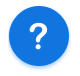

In [22]:
print(raw)

In [8]:
from lxml import html

# Parse HTML
tree = html.fromstring(raw)

# Use XPath to find the div by id
target_div = tree.xpath('//div[@id="ctl00_PlaceHolderMain_dvContent"]')

if target_div:
    # Get HTML string of the div *including* its contents
    content_html = html.tostring(target_div[0], pretty_print=True, encoding='unicode')
    print(content_html)
else:
    print("Div not found.")

<div id="ctl00_PlaceHolderMain_dvContent" class="ACA_RightItem record-detail">

            <div class="record-summary">
                <div class="rec-left">
                    <h1>
                        <span id="ctl00_PlaceHolderMain_per_permitDetail_label_permit"><font style="TEXT-ALIGN: left">Permit</font></span> <span id="ctl00_PlaceHolderMain_lblPermitNumber" dir="ltr">R-NEW-2025-0432</span>: </h1>
                    <h1>
                        <span id="ctl00_PlaceHolderMain_lblPermitType" class="span-permittype">New Single Family Residential</span>
</h1>

                    <div id="ctl00_PlaceHolderMain_divRecordStatus" class="dv-recordstatus">
                        <h1>
                            <span id="ctl00_PlaceHolderMain_lblRecordStatusTitle">Record Status:</span> <span id="ctl00_PlaceHolderMain_lblRecordStatus">Inspection Phase</span>
</h1>
                    </div>
                    
                </div>
                <div class="rec-right">
       

In [ ]:
def extract_parcel_info(tree):
    # Get all text inside the Parcel block
    parcel_block = tree.xpath('//div[@id="ctl00_PlaceHolderMain_PermitDetailList1_palParceList"]//text()')
    parcel_block = [text.strip() for text in parcel_block if text.strip()]

    # Match and extract key fields
    parcel_info = {
        "parcel_number": next((t.split("Parcel Number:")[1] for t in parcel_block if "Parcel Number:" in t), None),
        "block": next((t.split("Block:")[1] for t in parcel_block if t.startswith("Block:")), None),
        "lot": next((t.split("Lot:")[1] for t in parcel_block if t.startswith("Lot:")), None),
        "subdivision": next((t.split("Subdivision:")[1] for t in parcel_block if "Subdivision:" in t), None)
    }

    return parcel_info

import re

def extract_lines_before_address(tree):
    # Get all text fragments in order
    lines = tree.xpath('//table[@id="tbl_licensedps"]//td[2]//text()')
    lines = [line.strip() for line in lines if line.strip()]

    name_lines = []
    i = 0

    address_pattern = re.compile(
        r'.*\d{1,5}.*\b(?:Rd|St|Ave|Blvd|Dr|Ln|Way|Ct|Cir|Circle|Ste|Suite)\b.*',
        re.IGNORECASE
    )

    while i < len(lines):
        line = lines[i]
        if address_pattern.match(line):
            break  # stop before first address line
        name_lines.append(line)
        i += 1

    return name_lines

def extract_property_owner_info(tree):
    # Locate the <div> that contains the h2 "Property Owner information"
    section = tree.xpath('//h2[contains(text(), "Property Owner information")]/ancestor::div[contains(@class, "MoreDetail_ItemCol")]')[0]

    def get(xpath):
        found = section.xpath(xpath)
        return found[0].strip() if found else None

    return {
        "first_name": get('.//span[@class="contactinfo_firstname"]/text()'),
        "last_name": get('.//span[@class="contactinfo_lastname"]/text()'),
        "business_name": get('.//span[@class="contactinfo_businessname"]/text()'),
        "address": get('.//span[@class="contactinfo_addressline1"]/text()'),
        "city": get('//span[@class="contactinfo_region"][1]/text()').replace(',',''),
        "state": get('//span[@class="contactinfo_region"][2]/text()').replace(',', '').replace(',','') if get('//span[@class="contactinfo_region"][2]/text()') else None,
        "zip": get('//span[@class="contactinfo_region"][3]/text()').replace(',',''),
        "home_phone": get('.//span[@class="contactinfo_phone1"]//div[@class="ACA_PhoneNumberLTR"]/text()'),
        "work_phone": get('.//span[@class="contactinfo_phone3"]//div[@class="ACA_PhoneNumberLTR"]/text()'),
        "mobile_phone": get('.//span[@class="contactinfo_phone2"]//div[@class="ACA_PhoneNumberLTR"]/text()'),
        "fax": get('.//span[@class="contactinfo_fax"]//div[@class="ACA_PhoneNumberLTR"]/text()'),
        "email": get('.//span[@class="contactinfo_email"]//td/text()')
    }

def extract_contact_info(tree):
    # Locate the <div> that contains the h2 "Contact information"
    section = tree.xpath('//h2[contains(text(), "Contact information")]/ancestor::div[contains(@class, "MoreDetail_ItemCol")]')[0]

    def get(xpath):
        found = section.xpath(xpath)
        return found[0].strip() if found else None

    return {
        "first_name": get('.//span[@class="contactinfo_firstname"]/text()'),
        "last_name": get('.//span[@class="contactinfo_lastname"]/text()'),
        "address": get('.//span[@class="contactinfo_addressline1"]/text()'),
        "city": get('//span[@class="contactinfo_region"][1]/text()').replace(',',''),
        "state": get('//span[@class="contactinfo_region"][2]/text()').replace(',', '').replace(',','') if get('//span[@class="contactinfo_region"][2]/text()') else None,
        "zip": get('//span[@class="contactinfo_region"][3]/text()').replace(',',''),
        "work_phone": get('.//span[@class="contactinfo_phone3"]//div[@class="ACA_PhoneNumberLTR"]/text()'),
        "mobile_phone": get('.//span[@class="contactinfo_phone2"]//div[@class="ACA_PhoneNumberLTR"]/text()'),
        "email": get('.//span[@class="contactinfo_email"]//td/text()')
    }



def extract_permit_info(html_string):
    tree = html.fromstring(html_string)

    def extract(xpath):
        result = tree.xpath(xpath)
        return result[0].strip() if result else None
    
    # Project Description
    project_lines = tree.xpath('//span[contains(@id, "project")]/following::table[1]//td[2]//text()')
    project_description = " ".join(line.strip() for line in project_lines if line.strip())

    parcel_info = extract_parcel_info(tree)
    lp = extract_lines_before_address(tree)

    base_xpath = '//h1[span[contains(text(), "Applicant")]]/following::table[1]'

    prop_owner = extract_property_owner_info(tree)
    contact_info = extract_contact_info(tree)


    output = {
        "permit_id": extract('//span[@id="ctl00_PlaceHolderMain_lblPermitNumber"]/text()'),
        "permit_type": extract('//span[@id="ctl00_PlaceHolderMain_lblPermitType"]/text()'),
        "record_status": extract('//span[@id="ctl00_PlaceHolderMain_lblRecordStatus"]/text()'),
        "work_location": extract('//div[@id="divWorkLocationInfo"]//span[@class="fontbold"]/text()'),
        "project_description": project_description,
        "applicant": {
            "first_name": extract('//span[@class="contactinfo_firstname"]/text()'),
            "last_name": extract('//span[@class="contactinfo_lastname"]/text()'),
            "address": extract('//span[@class="contactinfo_addressline1"]/text()'),
            "city": extract('//span[@class="contactinfo_region"][1]/text()').replace(',',''),
            "state": extract('//span[@class="contactinfo_region"][2]/text()').replace(',', '').replace(',','') if extract('//span[@class="contactinfo_region"][2]/text()') else None,
            "zip": extract('//span[@class="contactinfo_region"][3]/text()').replace(',',''),
            "work_phone": extract('//span[@class="contactinfo_phone3"]//div[@class="ACA_PhoneNumberLTR"]/text()'),
            "email": extract('//span[@class="contactinfo_email"]//td/text()')
    },
        
        "licensed_professional": lp,
        "property_owner_info": prop_owner,
        "contact_info": contact_info 
        
    }
    output.update(parcel_info)

    return output

In [86]:
extract_permit_info(raw)

{'permit_id': 'R-NEW-2025-0432',
 'permit_type': 'New Single Family Residential',
 'record_status': 'Inspection Phase',
 'work_location': '797 BUROAK',
 'project_description': 'Tresidio Homes OW 14-08 - SF New Single Family Home',
 'applicant': {'first_name': 'Tresidio',
  'last_name': 'Homes LLC',
  'address': '2973 N Eagle Rd',
  'city': 'Meridian',
  'state': 'ID',
  'zip': '83646',
  'work_phone': '12089177500',
  'email': 'office@tresidio.com'},
 'licensed_professional': ['office@tresidio.com', 'TH CONSTRUCTION LLC'],
 'property_owner_info': {'first_name': 'Tresidio',
  'last_name': 'Homes LLC',
  'business_name': 'TH Construction',
  'address': '2973 N Eagle Rd',
  'city': 'Meridian',
  'state': 'ID',
  'zip': '83646',
  'home_phone': '2089177500',
  'work_phone': '12089177500',
  'mobile_phone': None,
  'fax': None,
  'email': 'E-mail:'},
 'contact_info': {'first_name': 'Tresidio',
  'last_name': 'Homes LLC',
  'address': '2973 N Eagle Rd',
  'city': 'Meridian',
  'state': 'ID',

In [ ]:
import pandas as pd

lst = pd.read_csv('/Users/paigegiese/Downloads/RecordList20250711(1).csv')
lst['Date'] = pd.to_datetime(lst['Date'])

In [95]:
lst.shape

(4291, 8)

In [99]:
lst[lst['Permit Number'].str.startswith('R-NEW')]

,Date,Permit Number,Permit Type,Project Name,Address,Status,Short Notes,Unnamed: 7
125,2025-06-30,R-NEW-2025-0595,New Single Family Residential,HUBBLE HOMES - PRESCOTT RIDGE 28-9 - SF,"5547 W ARALIA DR, MERIDIAN ID 83646",In Progress,NaN,NaN
129,2025-06-30,R-NEW-2025-0594,New Single Family Residential,"Brighton Homes Idaho, Inc - SF","6512 S MOUNTAINTOP WAY, MERIDIAN ID 83642",In Progress,NaN,NaN
134,2025-06-30,R-NEW-2025-0593,New Single Family Residential,TOLL BROTHERS 21-31-12 (7219-0274) - SF,"6019 W PEWTER POINT ST, MERIDIAN ID 83646",Inspection Phase,NaN,NaN
192,2025-06-27,R-NEW-2025-0592,New Single Family Residential,Paul Silva - SF,"1193 W MALBAR ST, MERIDIAN ID 83646",Inspection Phase,NaN,NaN
196,2025-06-27,R-NEW-2025-0591,New Single Family Residential,TH Construction OW 11-05 - SF,"918 W BUROAK DR, MERIDIAN ID 83642",In Progress,NaN,NaN
...,...,...,...,...,...,...,...,...
4206,2025-04-02,R-NEW-2025-0293,New Single Family Residential,TOLL BROTHERS 08-34-12 (7219-0258) - SF,"5977 W SNOW CURRANT ST, MERIDIAN ID 83646",Inspection Phase,NaN,NaN
4211,2025-04-02,R-NEW-2025-0292,New Single Family Residential,Hubble Homes- Prescott Ridge 9-15 - SF,"5764 N BACKFIRE WAY, MERIDIAN ID 83646",Inspection Phase,NaN,NaN
4213,2025-04-02,R-NEW-2025-0291,New Single Family Residential,Hubble Homes - Prescott Ridge 16-9 - SF,"5714 N CHESTNUT HILL WAY, MERIDIAN ID 83646",Inspection Phase,NaN,NaN
4285,2025-04-01,R-NEW-2025-0289,New Single Family Residential,Kyle Jon Freischmidt - SF,"362 E JARVIS ST, MERIDIAN ID 83642",Inspection Phase,NaN,NaN


In [103]:
(lst['Permit Number'].str.split('-').apply(lambda s: s[:2])).value_counts()[:25]

Permit Number
[R, MEC]        421
[R, RETRO]      400
[R, ELC]        391
[R, EXC]        378
[R, PLM]        374
[R, TEMP]       335
[R, NEW]        303
[R, WH]         160
[R, FPL]        140
[C, MEC]        125
[R, ELCEX]      113
[C, ELC]        106
[R, WS]          92
[R, PATIO]       87
[R, PLMEX]       73
[C, PLM]         58
[C, SIGN]        55
[C, FSPK]        55
[C, TI]          50
[C, SIGNELC]     49
[C, FALM]        48
[R, ROOF]        42
[C, CO]          36
[C, EXC]         26
[R, SERVE]       21
Name: count, dtype: int64